# Analysis of UFO Reporting Frequency in the U.S.

In [71]:
import pandas as pd
from scipy.stats import t
from scipy.stats import norm

In [181]:
# Grabs UFO Data, cleans it, and then finds count of reports per day
df = pd.read_csv('UFO_Final.csv',dtype='string')
df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')
df['Date'] = pd.to_datetime(df['Date'], format = '%m%d%Y')
df['Date'] = df['Date'].dt.floor('D')
df = df[pd.notnull(df['Date'])]
df = df[df['Date'].between('1950-01-01', pd.datetime.today())]
counts = df.pivot_table(columns = 'Date',aggfunc='size')

C:\Users\nickc\AppData\Local\Temp/ipykernel_8196/1930620687.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df = df[df['Date'].between('1950-01-01', pd.datetime.today())]


In [220]:
# Grab movie data, drop bad columns, extract df of titles / coresponding release dates.
# Possible to filter by gross earnings?

df2 = pd.read_csv('Keyword_Alien.csv')
# clean up the movie data //// hopefully won't be necessary once you fix bugs in scrape_imdb.ipynb
columns = ['Index','Title','IMDB_Rating','Movie_Description','Release_Date', 'Budget',\
              'Gross_US_Canada', 'Opening_Weekend_US_Canada', 'Gross_Worldwide']
df2.columns = columns
df2 = df2.drop('Index',1)
df2 = df2.drop('Movie_Description',1)

# Get days where an alien movie was released //// WHILE KEEPING THE MOVIE ATTACHED
dates = df2['Release_Date'].values.tolist()
titles = df2['Title'].values.tolist()
gross_list = []
gross = pd.DataFrame(df2['Gross_US_Canada'].values.tolist(),dtype='string')
for idx,row in gross.iterrows():
    if type(row[0]) == str:
        gross_list.append(row[0].replace('$','').replace(',','').replace('(estimated)',''))
    else:
        gross_list.append('')
releases = pd.DataFrame(columns = ['Title','Release_Date','Gross'])
releases['Title'] = titles
releases['Release_Date'] = dates
releases['Gross'] = gross_list
releases = releases.dropna()
releases['Release_Date'] = pd.to_datetime(releases['Release_Date'])
releases = releases.sort_values(by='Release_Date')

## #1: Analyze counts in context of movie release dates

In [223]:
# for each day a movie was released, find prior/post counts
greater = 0
lesser = 0
increasers = []
non_increasers = []
# make a cutoff date about 3 months prior. Sightings are rarely posted to the site within 3 months.
cutoff_date = pd.Timestamp.today() - pd.Timedelta(weeks=12)
print(cutoff_date)
for idx,row in releases.iterrows():
    title = row['Title']
    date = row['Release_Date']
    
    # check that the movie wasn't released too recently
    if date > cutoff_date:
        continue
        
    # Make range of dates n days in the past
    prior_start = date - pd.Timedelta('60 days')
    count = 0
    prior_period = []
    while count != 60:
        prior_period.append(prior_start + pd.Timedelta(days=count))
        count += 1
        
    # grab counts of all days that fall in prior_period
    total_prior = 0
    for day in prior_period:
        if day in counts:
            total_prior += counts.loc[day]
            
    # Make range of dates n days in the future
    count = 1
    post_period = []
    while count != 61:
        post_period.append(date + pd.Timedelta(days=count))
        count += 1
    
    # grab counts of all days that fall in post_period
    total_post = 0
    for day in post_period:
        if day in counts:
            total_post += counts.loc[day]
    
    # skip if no reports data surrounding the movie
    if total_prior == 0 or total_post == 0:
        continue
    
    # find average of each group
    average_prior = total_prior/len(prior_period)
    average_post = total_post/len(post_period)
    
    # find sample standard deviations
    squared_diff = 0
    prior_samples = 0
    for day in prior_period:
        if day in counts:
            squared_diff += (counts.loc[day]-average_prior)**2
            prior_samples += 1
    std_prior = (squared_diff/(prior_samples-1))**(0.5)
    
    squared_diff = 0
    post_samples = 0
    for day in post_period:
        if day in counts:
            squared_diff += (counts.loc[day]-average_post)**2
            post_samples += 1
    std_post = (squared_diff/(post_samples-1))**(0.5)
            
    standard_error = (std_prior**2/(prior_samples-1) + std_post**2/(post_samples-1))**(0.5) 
    test_statistic = (average_post-average_prior)/standard_error
    alpha = 0.10
    critical_value = t.ppf(1-alpha,df=post_samples+prior_samples-2)
    rejected = test_statistic >= critical_value
    
    #print(f'Movie: {title}   \nDate: {date}    \nAverages: {average_prior} {average_post}\
    #Rejected = {rejected}')
    
    if rejected:
        greater += 1
        increasers.append(title)
    else:
        lesser += 1
        non_increasers.append(title)
        
# calculate p = greater_counter/(greater_counter + lesser_counter)
# one-tailed binomial test H0: p = 0.5 versus H1: p > 0.5
print(f'Portion of samples which saw an increase in average counts \
following movie release: {greater/(greater+lesser)}')

2021-10-27 14:37:16.766170
Portion of samples which saw an increase in average counts following movie release: 0.2577777777777778


In [224]:
# One-tailed Binomial test: p != 0.5
n = len(increasers)+len(non_increasers)
k = len(increasers)
test_stat = (k-n*.5)/(n*0.5*0.5)**(0.5)
alpha = 0.10
critical_value = norm.ppf(alpha)
print(f'Reject H_0: P = 0.5 in favor of H_1: P > 0.5: {test_stat > critical_value}')
print(f'Reject H_0: P = 0.5 in favor of H_1: P < 0.5: {test_stat < -critical_value}')

Reject H_0: P = 0.5 in favor of H_1: P > 0.5: False
Reject H_0: P = 0.5 in favor of H_1: P < 0.5: True


In [185]:
print(increasers)

['Star Wars: Episode IV - A New Hope', 'Space Jam', 'Dark City', 'Star Wars: Episode I - The Phantom Menace', 'The Iron Giant', 'Battlefield Earth', 'Evolution', 'Star Wars: Episode II - Attack of the Clones', 'Lilo & Stitch', 'Men in Black II', 'Star Wars: Episode III - Revenge of the Sith', 'Mysterious Skin', 'War of the Worlds', 'Happy Feet', 'Fantastic 4: Rise of the Silver Surfer', 'Transformers', 'Aliens vs. Predator: Requiem', 'Indiana Jones and the Kingdom of the Crystal Skull', 'Star Trek', 'Transformers: Revenge of the Fallen', 'Toy Story 3', 'Attack the Block', 'Super 8', 'Green Lantern', 'Transformers: Dark of the Moon', 'John Carter', 'The Avengers', 'Battleship', 'Men in Black 3', 'Prometheus', 'The Host', 'Oblivion', 'Star Trek Into Darkness', 'After Earth', 'Man of Steel', 'Edge of Tomorrow', 'Transformers: Age of Extinction', 'Teenage Mutant Ninja Turtles: Out of the Shadows', 'Independence Day: Resurgence', 'Star Trek Beyond', 'The Space Between Us', 'Absolutely Anyth

In [95]:
print(non_increasers)

['Solaris', 'The Holy Mountain', 'The Rocky Horror Picture Show', 'Close Encounters of the Third Kind', 'Superman', 'Invasion of the Body Snatchers', 'Phantasm', 'Alien', 'Life of Brian', 'Star Trek: The Motion Picture', 'Stalker', 'Star Wars: Episode V - The Empire Strikes Back', 'Flash Gordon', 'Superman II', 'Heavy Metal', 'Star Trek II: The Wrath of Khan', 'E.T. the Extra-Terrestrial', 'The Thing', 'Star Wars: Episode VI - Return of the Jedi', 'Krull', 'Repo Man', 'The Last Starfighter', 'The Adventures of Buckaroo Banzai Across the 8th Dimension', 'Supergirl', 'Starman', 'Lifeforce', 'Cocoon', 'Explorers', 'Enemy Mine', 'Critters', 'Aliens', 'Howard the Duck', 'Flight of the Navigator', 'From Beyond', 'The Wraith', 'Star Trek IV: The Voyage Home', 'Little Shop of Horrors', 'Predator', 'Spaceballs', 'Masters of the Universe', '*batteries not included', 'Killer Klowns from Outer Space', 'The Blob', 'Mac and Me', 'They Live', 'My Stepmother Is an Alien', 'Earth Girls Are Easy', 'Bad 

# Next Steps:
1. Think about weighting each movie's contribution to the portion calculation based on box office performance? OR below
2. Construct descriptive analytics for the increasers and non_increasers groups
    average movie popularity (based on position in releases df)
    average box office performance
    average imdb rating
3. Use the above to argue that the non-increasers simply weren't popular enough to influence reports freq.
4. Overall, make observations on the results of the analysis but also offer up reasons why we might be seeing those results.  No definitive claims can be made at this point.

In [32]:
import matplotlib.pyplot as plt

## #2: Analysis of 'counts'

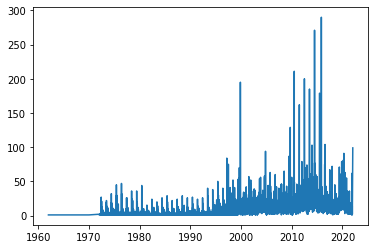

In [74]:
plt.plot(counts)
plt.show()

## #3: Analysis of increaser/non increaser groups

In [225]:
inc_list = []
for idx,row in df2.iterrows():
    if row['Title'] in increasers:
        inc_list.append(row)
inc_df = pd.DataFrame(inc_list,dtype='string')

dec_list = []
for idx,row in df2.iterrows():
    if row['Title'] in non_increasers:
        dec_list.append(row)
dec_df = pd.DataFrame(dec_list,dtype='string')

In [226]:
inc_df = inc_df.dropna()
inc_val_list = []
for idx,row in inc_df.iterrows():
    row['Gross_US_Canada'] = row['Gross_US_Canada'].replace("$","")
    row['Gross_US_Canada'] = row['Gross_US_Canada'].replace(",","")
    row['Gross_US_Canada'] = row['Gross_US_Canada'].replace("(estimated)","")
    inc_val_list.append(row['Gross_US_Canada'])
df_inc_val = pd.DataFrame(inc_val_list,dtype='int',columns=['values'])

dec_df = dec_df.dropna()
dec_val_list = []
for idx,row in dec_df.iterrows():
    row['Gross_US_Canada'] = row['Gross_US_Canada'].replace("$","")
    row['Gross_US_Canada'] = row['Gross_US_Canada'].replace(",","")
    row['Gross_US_Canada'] = row['Gross_US_Canada'].replace("(estimated)","")
    dec_val_list.append(row['Gross_US_Canada'])
df_dec_val = pd.DataFrame(dec_val_list,dtype='int',columns=['values'])

In [227]:
print(f"Increaser mean boxoffice: {df_inc_val['values'].mean()}")
print(f"Decreasers mean boxoffice: {df_dec_val['values'].mean()}")

Increaser mean boxoffice: 194440749.27450982
Decreasers mean boxoffice: 105221718.17449665


### The above tells me that the increasing/decreasing may have to do with box office average?